=== НАСТРОЙКИ АНАЛИЗА ===
Символ: BTCUSDT
Таймфрейм: 15m
Период: 01.01.2025 - 20.05.2025
ZigZag отклонение: 3%
Порог группировки цен: 0.2%
Порог пробития: 0.1%
Порог подтверждения: 0.5%
Толерантность возврата: 0.05%

Загрузка данных BTCUSDT с 01.01.2025 по 20.05.2025...
Загружено 1000 свечей.
Расчет индикатора ZigZag...
Определение уровней поддержки и сопротивления...
Найдено 1 уровней поддержки и 2 уровней сопротивления.
Уровни сопротивления: ['94098.91', '102724.38']

КОЛИЧЕСТВЕННЫЙ АНАЛИЗ ПРОБИТИЙ УРОВНЕЙ СОПРОТИВЛЕНИЯ

Анализ уровня сопротивления: 94098.91
  Пробитие в 2025-01-01 14:00:00: 94245.19
    Максимальная цена: 94450.85
    Максимальное отклонение: 0.37% (351.94 USDT)
    Возврат к уровню: 2025-01-01 14:15:00 по цене 93919.99
    Время выше уровня: 0.25 часов
    Пробитие подтверждено: False
  Пробитие в 2025-01-01 18:15:00: 94208.43
    Максимальная цена: 102724.38
    Максимальное отклонение: 9.17% (8625.47 USDT)
    Возврат к уровню: 2025-01-08 17:00:00 по цене 93859.5

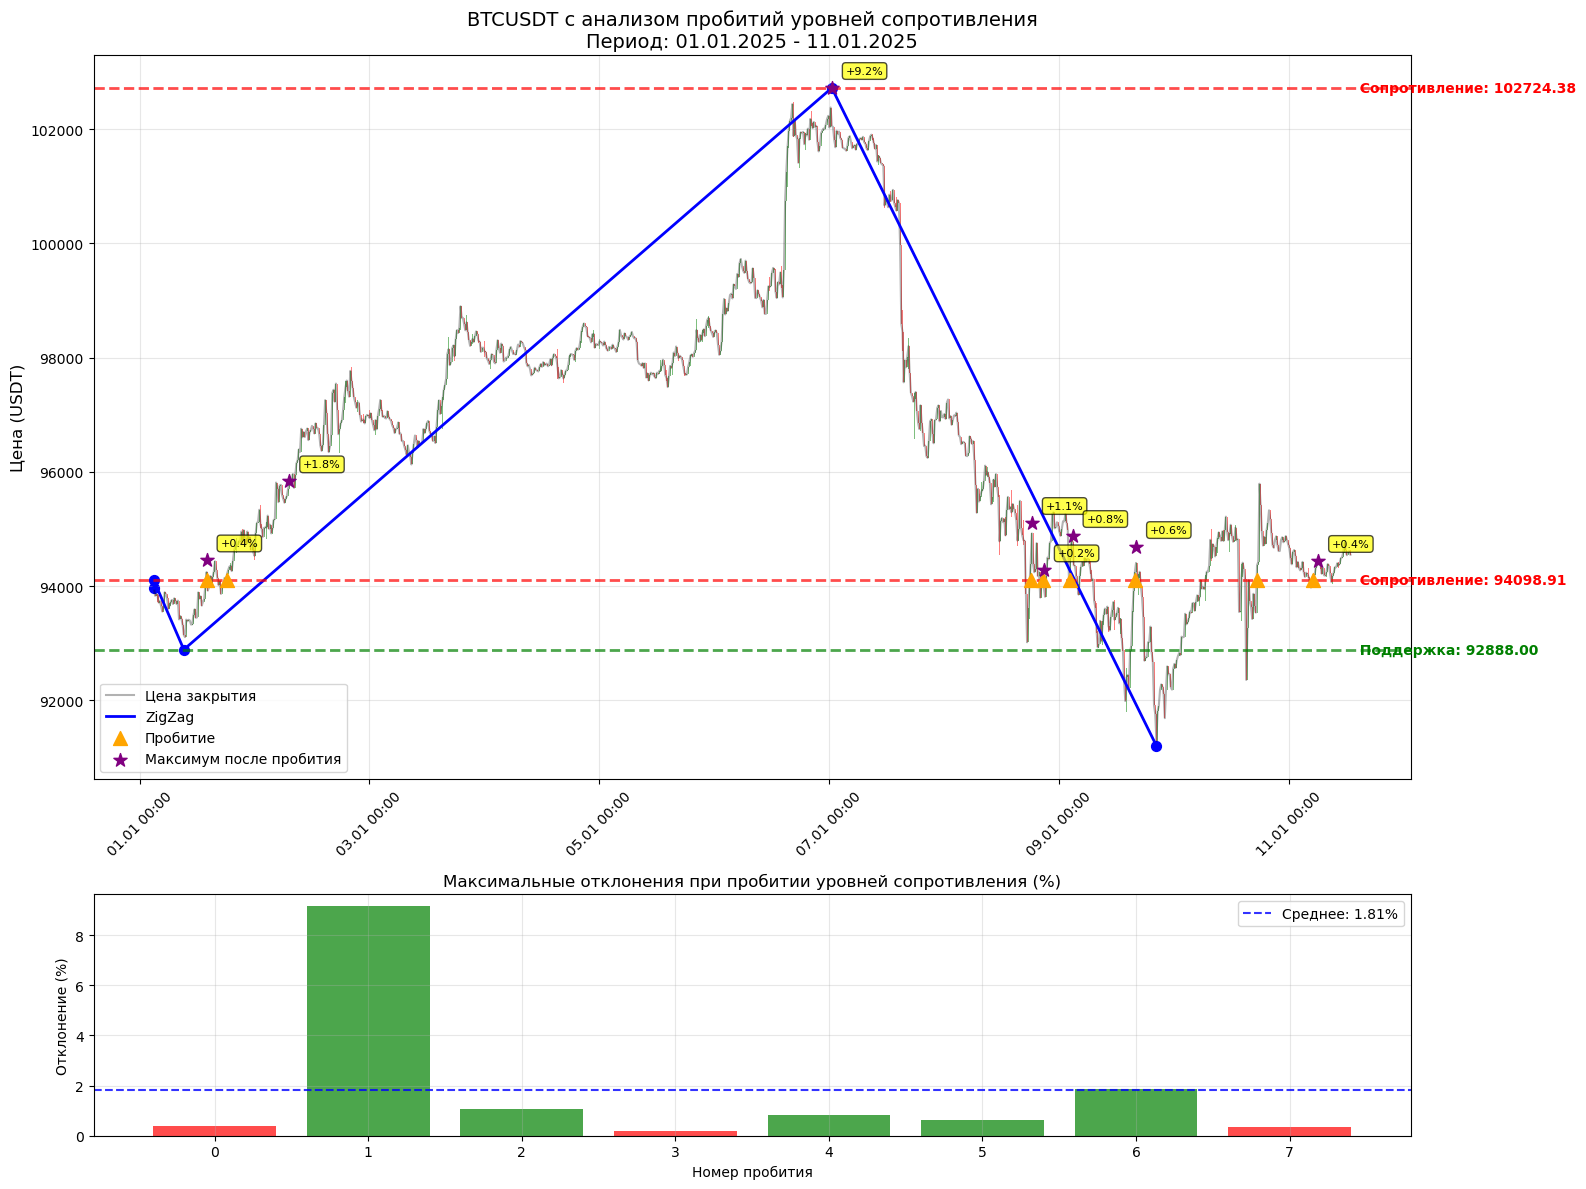


Анализ завершен. График сохранен в файл 'btcusdt_breakout_analysis.png'.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# =============================================================================
# НАСТРАИВАЕМЫЕ ПАРАМЕТРЫ - ИЗМЕНЯЙТЕ ПО НЕОБХОДИМОСТИ
# =============================================================================

# Основные параметры данных
SYMBOL = "BTCUSDT"
INTERVAL = "15m"
START_DATE = "01.01.2025"
END_DATE = "20.05.2025"

# Параметры ZigZag индикатора
ZIGZAG_DEVIATION = 3  # Процентное отклонение для определения точек разворота

# Параметры определения уровней поддержки/сопротивления
PRICE_THRESHOLD = 0.2  # Пороговое значение для группировки близких цен (в процентах)
TIME_THRESHOLD = 10    # Минимальное количество свечей между уровнями

# Параметры анализа пробитий
BREAKOUT_THRESHOLD = 0.1     # Минимальный процент пробития для учета (по умолчанию 0.1%)
RETURN_TOLERANCE = 0.05      # Толерантность для определения возврата к уровню (0.05%)
CONFIRMATION_THRESHOLD = 0.5 # Порог для подтверждения пробития (0.5%)

# Параметры графика
FIGURE_SIZE = (16, 12)       # Размер графика
DPI = 300                    # Разрешение сохраняемого графика
CANDLE_ALPHA = 0.5           # Прозрачность свечей
PRICE_LINE_ALPHA = 0.3       # Прозрачность линии цены

# =============================================================================
# ОСНОВНОЙ КОД - НЕ ИЗМЕНЯЙТЕ БЕЗ НЕОБХОДИМОСТИ
# =============================================================================

# Функция для получения данных BTCUSDT с Binance API
def get_binance_data(symbol, interval, start_date, end_date):
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Преобразование дат в миллисекунды (timestamp)
    start_ms = int(datetime.strptime(start_date, "%d.%m.%Y").timestamp() * 1000)
    end_ms = int(datetime.strptime(end_date, "%d.%m.%Y").timestamp() * 1000)
    
    # Параметры запроса
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_ms,
        "endTime": end_ms,
        "limit": 1000  # Максимальное количество свечей
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Создание DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                    'close_time', 'quote_asset_volume', 'number_of_trades',
                                    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    
    # Преобразование типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    return df

# Функция для расчета индикатора ZigZag
def calculate_zigzag(df, deviation=ZIGZAG_DEVIATION):
    """
    Рассчитывает индикатор ZigZag на основе ценовых данных.
    
    Параметры:
    df: DataFrame с данными цен
    deviation: процентное отклонение для определения точек разворота
    
    Возвращает: список точек ZigZag (индекс, цена)
    """
    high = df['high'].values
    low = df['low'].values
    price_range = max(df['high'].max() - df['low'].min(), 1e-10)
    dev_threshold = price_range * deviation / 100
    
    zigzag_points = []
    current_dir = 0  # 0: неопределенно, 1: восходящий тренд, -1: нисходящий тренд
    last_high_idx = 0
    last_low_idx = 0
    last_high = high[0]
    last_low = low[0]
    
    for i in range(1, len(df)):
        # Проверка на новый максимум
        if high[i] > last_high:
            last_high = high[i]
            last_high_idx = i
            
            # Если мы находимся в нисходящем тренде и отклонение достаточно большое
            if current_dir == -1 and last_high - last_low >= dev_threshold:
                zigzag_points.append((last_low_idx, last_low))
                current_dir = 1
                
        # Проверка на новый минимум
        if low[i] < last_low:
            last_low = low[i]
            last_low_idx = i
            
            # Если мы находимся в восходящем тренде и отклонение достаточно большое
            if current_dir == 1 and last_high - last_low >= dev_threshold:
                zigzag_points.append((last_high_idx, last_high))
                current_dir = -1
                
        # Инициализация направления, если оно еще не определено
        if current_dir == 0 and i > 10:
            if last_high - low[0] > high[0] - last_low:
                current_dir = -1
                zigzag_points.append((0, high[0]))
            else:
                current_dir = 1
                zigzag_points.append((0, low[0]))
    
    # Добавление последней точки
    if current_dir == 1:
        zigzag_points.append((last_high_idx, last_high))
    else:
        zigzag_points.append((last_low_idx, last_low))
    
    return zigzag_points

# Функция для определения уровней поддержки и сопротивления
def find_support_resistance(df, zigzag_points, price_threshold=PRICE_THRESHOLD, time_threshold=TIME_THRESHOLD):
    """
    Находит уровни поддержки и сопротивления на основе точек ZigZag.
    
    Параметры:
    df: DataFrame с данными цен
    zigzag_points: список точек ZigZag
    price_threshold: пороговое значение для группировки близких цен (в процентах)
    time_threshold: минимальное количество свечей между уровнями
    
    Возвращает: кортеж (уровни поддержки, уровни сопротивления)
    """
    # Извлечение цен из точек ZigZag
    prices = [point[1] for point in zigzag_points]
    indices = [point[0] for point in zigzag_points]
    
    # Определение максимальной и минимальной цены для процентного порога
    price_range = max(prices) - min(prices)
    threshold = price_range * price_threshold / 100
    
    # Списки для уровней поддержки и сопротивления
    support_levels = []
    resistance_levels = []
    
    # Классификация точек как впадины (поддержка) или пики (сопротивление)
    for i in range(1, len(prices) - 1):
        idx = indices[i]
        price = prices[i]
        
        # Если точка - минимум (поддержка)
        if price < prices[i - 1] and price < prices[i + 1]:
            # Проверка, близка ли цена к существующим уровням поддержки
            is_new_level = True
            for level in support_levels:
                if abs(price - level) < threshold:
                    is_new_level = False
                    break
            
            if is_new_level:
                support_levels.append(price)
        
        # Если точка - максимум (сопротивление)
        elif price > prices[i - 1] and price > prices[i + 1]:
            # Проверка, близка ли цена к существующим уровням сопротивления
            is_new_level = True
            for level in resistance_levels:
                if abs(price - level) < threshold:
                    is_new_level = False
                    break
            
            if is_new_level:
                resistance_levels.append(price)
    
    return support_levels, resistance_levels

# Функция для анализа пробитий уровней сопротивления
def analyze_resistance_breakouts(df, resistance_levels, breakout_threshold=BREAKOUT_THRESHOLD):
    """
    Анализирует пробития уровней сопротивления и рассчитывает отклонения.
    
    Параметры:
    df: DataFrame с данными цен
    resistance_levels: список уровней сопротивления
    breakout_threshold: минимальный процент пробития для учета
    
    Возвращает: словарь с результатами анализа
    """
    breakout_analysis = {
        'resistance_level': [],
        'breakout_start_time': [],
        'breakout_start_price': [],
        'max_price_after_breakout': [],
        'max_deviation_percent': [],
        'max_deviation_absolute': [],
        'return_to_level_time': [],
        'return_to_level_price': [],
        'duration_above_level': [],
        'breakout_confirmed': []
    }
    
    for resistance_level in resistance_levels:
        print(f"\nАнализ уровня сопротивления: {resistance_level:.2f}")
        
        # Поиск моментов пробития уровня сопротивления
        i = 0
        while i < len(df) - 1:
            # Проверяем, произошло ли пробитие уровня сопротивления
            if (df['close'].iloc[i] <= resistance_level and 
                df['close'].iloc[i + 1] > resistance_level * (1 + breakout_threshold/100)):
                
                # Найдено пробитие уровня сопротивления
                breakout_start_time = df['timestamp'].iloc[i + 1]
                breakout_start_price = df['close'].iloc[i + 1]
                
                print(f"  Пробитие в {breakout_start_time}: {breakout_start_price:.2f}")
                
                # Отслеживаем движение цены после пробития
                max_price = breakout_start_price
                max_price_time = breakout_start_time
                return_to_level_time = None
                return_to_level_price = None
                
                # Ищем максимальную цену после пробития и момент возврата
                j = i + 1
                while j < len(df):
                    current_price = df['high'].iloc[j]
                    current_close = df['close'].iloc[j]
                    current_time = df['timestamp'].iloc[j]
                    
                    # Обновляем максимальную цену
                    if current_price > max_price:
                        max_price = current_price
                        max_price_time = current_time
                    
                    # Проверяем возврат к уровню сопротивления
                    if (current_close <= resistance_level * (1 + RETURN_TOLERANCE/100) and 
                        return_to_level_time is None):
                        return_to_level_time = current_time
                        return_to_level_price = current_close
                        break
                    
                    j += 1
                
                # Если не было возврата к уровню до конца данных
                if return_to_level_time is None:
                    return_to_level_time = df['timestamp'].iloc[-1]
                    return_to_level_price = df['close'].iloc[-1]
                
                # Расчет отклонений
                max_deviation_absolute = max_price - resistance_level
                max_deviation_percent = (max_price / resistance_level - 1) * 100
                
                # Расчет продолжительности выше уровня
                duration_above_level = (return_to_level_time - breakout_start_time).total_seconds() / 3600  # в часах
                
                # Определяем, было ли пробитие подтверждено
                breakout_confirmed = max_deviation_percent > CONFIRMATION_THRESHOLD
                
                # Сохраняем результаты
                breakout_analysis['resistance_level'].append(resistance_level)
                breakout_analysis['breakout_start_time'].append(breakout_start_time)
                breakout_analysis['breakout_start_price'].append(breakout_start_price)
                breakout_analysis['max_price_after_breakout'].append(max_price)
                breakout_analysis['max_deviation_percent'].append(max_deviation_percent)
                breakout_analysis['max_deviation_absolute'].append(max_deviation_absolute)
                breakout_analysis['return_to_level_time'].append(return_to_level_time)
                breakout_analysis['return_to_level_price'].append(return_to_level_price)
                breakout_analysis['duration_above_level'].append(duration_above_level)
                breakout_analysis['breakout_confirmed'].append(breakout_confirmed)
                
                print(f"    Максимальная цена: {max_price:.2f}")
                print(f"    Максимальное отклонение: {max_deviation_percent:.2f}% ({max_deviation_absolute:.2f} USDT)")
                print(f"    Возврат к уровню: {return_to_level_time} по цене {return_to_level_price:.2f}")
                print(f"    Время выше уровня: {duration_above_level:.2f} часов")
                print(f"    Пробитие подтверждено: {breakout_confirmed}")
                
                # Переходим к поиску следующего пробития после момента возврата
                next_start = j if j < len(df) else len(df) - 1
                i = next_start
            else:
                i += 1
    
    return breakout_analysis

# Функция для расчета статистических метрик
def calculate_breakout_statistics(breakout_analysis):
    """
    Рассчитывает статистические метрики для пробитий уровней сопротивления.
    
    Параметры:
    breakout_analysis: результаты анализа пробитий
    
    Возвращает: словарь со статистикой
    """
    if not breakout_analysis['max_deviation_percent']:
        return {
            'total_breakouts': 0,
            'confirmed_breakouts': 0,
            'avg_deviation_percent': 0,
            'max_deviation_percent': 0,
            'std_deviation_percent': 0,
            'avg_deviation_absolute': 0,
            'max_deviation_absolute': 0,
            'avg_duration_hours': 0,
            'max_duration_hours': 0
        }
    
    deviations_percent = breakout_analysis['max_deviation_percent']
    deviations_absolute = breakout_analysis['max_deviation_absolute']
    durations = breakout_analysis['duration_above_level']
    confirmed_breakouts = sum(breakout_analysis['breakout_confirmed'])
    
    statistics = {
        'total_breakouts': len(deviations_percent),
        'confirmed_breakouts': confirmed_breakouts,
        'confirmation_rate': confirmed_breakouts / len(deviations_percent) * 100,
        'avg_deviation_percent': np.mean(deviations_percent),
        'max_deviation_percent': np.max(deviations_percent),
        'min_deviation_percent': np.min(deviations_percent),
        'std_deviation_percent': np.std(deviations_percent),
        'median_deviation_percent': np.median(deviations_percent),
        'avg_deviation_absolute': np.mean(deviations_absolute),
        'max_deviation_absolute': np.max(deviations_absolute),
        'min_deviation_absolute': np.min(deviations_absolute),
        'avg_duration_hours': np.mean(durations),
        'max_duration_hours': np.max(durations),
        'min_duration_hours': np.min(durations)
    }
    
    return statistics

# Функция для построения графика с отмеченными пробитиями
def plot_chart_with_breakout_analysis(df, zigzag_points, support_levels, resistance_levels, breakout_analysis):
    """
    Строит график цены с индикатором ZigZag, уровнями поддержки/сопротивления и пробитиями.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE, height_ratios=[3, 1])
    
    # Верхний график - основной график цены
    # Построение графика цены
    ax1.plot(df['timestamp'], df['close'], color='black', alpha=PRICE_LINE_ALPHA, label='Цена закрытия')
    
    # Построение свечного графика
    width = 0.8 * (df['timestamp'].iloc[1] - df['timestamp'].iloc[0]).total_seconds() / 86400
    up = df[df['close'] >= df['open']]
    down = df[df['close'] < df['open']]
    
    # Зеленые свечи (цена растет)
    ax1.bar(up['timestamp'], up['close'] - up['open'], width, bottom=up['open'], color='green', alpha=CANDLE_ALPHA)
    ax1.bar(up['timestamp'], up['high'] - up['close'], width*0.1, bottom=up['close'], color='green', alpha=CANDLE_ALPHA)
    ax1.bar(up['timestamp'], up['low'] - up['open'], width*0.1, bottom=up['open'], color='green', alpha=CANDLE_ALPHA)
    
    # Красные свечи (цена падает)
    ax1.bar(down['timestamp'], down['close'] - down['open'], width, bottom=down['open'], color='red', alpha=CANDLE_ALPHA)
    ax1.bar(down['timestamp'], down['high'] - down['open'], width*0.1, bottom=down['open'], color='red', alpha=CANDLE_ALPHA)
    ax1.bar(down['timestamp'], down['low'] - down['close'], width*0.1, bottom=down['close'], color='red', alpha=CANDLE_ALPHA)
    
    # Построение линий ZigZag
    zigzag_indices = [point[0] for point in zigzag_points]
    zigzag_prices = [point[1] for point in zigzag_points]
    zigzag_timestamps = [df['timestamp'].iloc[idx] for idx in zigzag_indices]
    
    ax1.plot(zigzag_timestamps, zigzag_prices, color='blue', linewidth=2, label='ZigZag')
    ax1.scatter(zigzag_timestamps, zigzag_prices, color='blue', s=50)
    
    # Построение уровней поддержки
    for level in support_levels:
        ax1.axhline(y=level, color='green', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(df['timestamp'].iloc[-1], level, f'  Поддержка: {level:.2f}', 
                verticalalignment='center', color='green', fontweight='bold')
    
    # Построение уровней сопротивления
    for level in resistance_levels:
        ax1.axhline(y=level, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(df['timestamp'].iloc[-1], level, f'  Сопротивление: {level:.2f}', 
                verticalalignment='center', color='red', fontweight='bold')
    
    # Отметка пробитий на графике
    for i in range(len(breakout_analysis['breakout_start_time'])):
        start_time = breakout_analysis['breakout_start_time'][i]
        max_price = breakout_analysis['max_price_after_breakout'][i]
        resistance_level = breakout_analysis['resistance_level'][i]
        deviation = breakout_analysis['max_deviation_percent'][i]
        
        # Отмечаем точку начала пробития
        ax1.scatter(start_time, resistance_level, color='orange', s=100, marker='^', 
                   label='Пробитие' if i == 0 else "", zorder=5)
        
        # Отмечаем максимальную точку после пробития
        # Находим время максимальной цены
        max_time_idx = df[df['high'] == max_price].index
        if len(max_time_idx) > 0:
            max_time = df.loc[max_time_idx[0], 'timestamp']
            ax1.scatter(max_time, max_price, color='purple', s=100, marker='*', 
                       label='Максимум после пробития' if i == 0 else "", zorder=5)
            
            # Добавляем аннотацию с процентом отклонения
            ax1.annotate(f'+{deviation:.1f}%', 
                        xy=(max_time, max_price), 
                        xytext=(10, 10), 
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        fontsize=8)
    
    # Настройка верхнего графика
    ax1.set_title(f'{SYMBOL} с анализом пробитий уровней сопротивления\n'
                 f'Период: {df["timestamp"].iloc[0].strftime("%d.%m.%Y")} - {df["timestamp"].iloc[-1].strftime("%d.%m.%Y")}',
                 fontsize=14)
    ax1.set_ylabel('Цена (USDT)', fontsize=12)
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Нижний график - гистограмма отклонений
    if breakout_analysis['max_deviation_percent']:
        ax2.bar(range(len(breakout_analysis['max_deviation_percent'])), 
               breakout_analysis['max_deviation_percent'],
               color=['green' if confirmed else 'red' for confirmed in breakout_analysis['breakout_confirmed']],
               alpha=0.7)
        ax2.set_title('Максимальные отклонения при пробитии уровней сопротивления (%)', fontsize=12)
        ax2.set_xlabel('Номер пробития', fontsize=10)
        ax2.set_ylabel('Отклонение (%)', fontsize=10)
        ax2.grid(alpha=0.3)
        
        # Добавляем среднюю линию
        avg_deviation = np.mean(breakout_analysis['max_deviation_percent'])
        ax2.axhline(y=avg_deviation, color='blue', linestyle='--', alpha=0.8, 
                   label=f'Среднее: {avg_deviation:.2f}%')
        ax2.legend()
    
    # Форматирование оси X для лучшего отображения дат
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('btcusdt_breakout_analysis.png', dpi=DPI, bbox_inches='tight')
    plt.show()

# Основной код
def main():
    print(f"=== НАСТРОЙКИ АНАЛИЗА ===")
    print(f"Символ: {SYMBOL}")
    print(f"Таймфрейм: {INTERVAL}")
    print(f"Период: {START_DATE} - {END_DATE}")
    print(f"ZigZag отклонение: {ZIGZAG_DEVIATION}%")
    print(f"Порог группировки цен: {PRICE_THRESHOLD}%")
    print(f"Порог пробития: {BREAKOUT_THRESHOLD}%")
    print(f"Порог подтверждения: {CONFIRMATION_THRESHOLD}%")
    print(f"Толерантность возврата: {RETURN_TOLERANCE}%")
    print(f"========================\n")
    
    # Получение данных
    print(f"Загрузка данных {SYMBOL} с {START_DATE} по {END_DATE}...")
    df = get_binance_data(SYMBOL, INTERVAL, START_DATE, END_DATE)
    print(f"Загружено {len(df)} свечей.")
    
    # Расчет индикатора ZigZag
    print("Расчет индикатора ZigZag...")
    zigzag_points = calculate_zigzag(df, ZIGZAG_DEVIATION)
    
    # Определение уровней поддержки и сопротивления
    print("Определение уровней поддержки и сопротивления...")
    support_levels, resistance_levels = find_support_resistance(df, zigzag_points, 
                                                            PRICE_THRESHOLD, 
                                                            TIME_THRESHOLD)
    
    print(f"Найдено {len(support_levels)} уровней поддержки и {len(resistance_levels)} уровней сопротивления.")
    print(f"Уровни сопротивления: {[f'{level:.2f}' for level in resistance_levels]}")
    
    # Анализ пробитий уровней сопротивления
    print("\n" + "="*50)
    print("КОЛИЧЕСТВЕННЫЙ АНАЛИЗ ПРОБИТИЙ УРОВНЕЙ СОПРОТИВЛЕНИЯ")
    print("="*50)
    
    breakout_analysis = analyze_resistance_breakouts(df, resistance_levels, BREAKOUT_THRESHOLD)
    
    # Расчет статистических метрик
    statistics = calculate_breakout_statistics(breakout_analysis)
    
    # Вывод статистических результатов
    print("\n" + "="*50)
    print("СТАТИСТИЧЕСКИЕ РЕЗУЛЬТАТЫ")
    print("="*50)
    
    print(f"Общее количество пробитий уровней сопротивления: {statistics['total_breakouts']}")
    print(f"Подтвержденных пробитий (>{CONFIRMATION_THRESHOLD}%): {statistics['confirmed_breakouts']}")
    print(f"Процент подтверждения пробитий: {statistics['confirmation_rate']:.1f}%")
    
    print(f"\nОТКЛОНЕНИЯ В ПРОЦЕНТАХ:")
    print(f"Среднее отклонение: {statistics['avg_deviation_percent']:.2f}%")
    print(f"Максимальное отклонение: {statistics['max_deviation_percent']:.2f}%")
    print(f"Минимальное отклонение: {statistics['min_deviation_percent']:.2f}%")
    print(f"Медианное отклонение: {statistics['median_deviation_percent']:.2f}%")
    print(f"Стандартное отклонение: {statistics['std_deviation_percent']:.2f}%")
    
    print(f"\nОТКЛОНЕНИЯ В АБСОЛЮТНЫХ ЗНАЧЕНИЯХ (USDT):")
    print(f"Среднее отклонение: {statistics['avg_deviation_absolute']:.2f} USDT")
    print(f"Максимальное отклонение: {statistics['max_deviation_absolute']:.2f} USDT")
    print(f"Минимальное отклонение: {statistics['min_deviation_absolute']:.2f} USDT")
    
    print(f"\nВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:")
    print(f"Среднее время выше уровня: {statistics['avg_duration_hours']:.2f} часов")
    print(f"Максимальное время выше уровня: {statistics['max_duration_hours']:.2f} часов")
    print(f"Минимальное время выше уровня: {statistics['min_duration_hours']:.2f} часов")
    
    # Создание DataFrame для детального анализа
    if breakout_analysis['resistance_level']:
        breakout_df = pd.DataFrame(breakout_analysis)
        
        print(f"\nДЕТАЛЬНАЯ ТАБЛИЦА ПРОБИТИЙ:")
        print("-" * 120)
        for i, row in breakout_df.iterrows():
            print(f"Пробитие #{i+1}:")
            print(f"  Уровень сопротивления: {row['resistance_level']:.2f} USDT")
            print(f"  Время пробития: {row['breakout_start_time']}")
            print(f"  Максимальная цена: {row['max_price_after_breakout']:.2f} USDT")
            print(f"  Отклонение: {row['max_deviation_percent']:.2f}% ({row['max_deviation_absolute']:.2f} USDT)")
            print(f"  Время выше уровня: {row['duration_above_level']:.2f} часов")
            print(f"  Подтверждено: {'Да' if row['breakout_confirmed'] else 'Нет'}")
            print("-" * 50)
    
    # Построение графика с анализом пробитий
    print("\nПостроение графика с анализом пробитий...")
    plot_chart_with_breakout_analysis(df, zigzag_points, support_levels, resistance_levels, breakout_analysis)
    
    print("\nАнализ завершен. График сохранен в файл 'btcusdt_breakout_analysis.png'.")

if __name__ == "__main__":
    main()